<a href="https://colab.research.google.com/github/bourama1/TH1zp/blob/main/TH1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zápočtový úkol 1 TH
Tento model je multiplayerová iterovaná verze hry kámen-nůžky-papír. Hra kámen-nůžky-papír je jednoduchá, avšak zajímavá, a často používaná hra, která se vyskytuje v různých situacích od neformálních her až po strategické rozhodování v počítačových algoritmech. Tato hra nabízí možnost zkoumat různé strategie a jejich účinnost v různých kontextech. Cílem této práce je prostřednictvím simulace hry kámen-nůžky-papír na sítích zkoumat účinnost různých strategií a jejich interakci s topologií sítě.

### Definice strategií
Definoval jsem několik jednoduchých a pár složitějších strategií, které jsou založeny na tazích protihráčích.
* always_rock = vždy hraje kámen = modrá barva
* always_paper = vždy hraje papír = zelená barva
* always_scissors = vždy hraje nůžky = červená barva
* random_without_bias = zcela náhodně zvolí = cyan barva
* random_with_bias = náhodně zvolí s biasem procentuálně určeným , tj probabilities (=[0.4, 0.3, 0.3]) = magenta barva
* based_on_history = zahraje to co by porazilo poslední soupeřovu volbu = žlutá barva
* copy_last_move = zahraje to co zahrál jeho soupeř posledně = oranžová barva
* pattern_based_strategy = pokud soupeř zahrál dvě kola po sobě stejně, tak zahraje to co by ho porazilo = fialová barva

Rovněž jsou zde definovány názvy a jednoznačně přiřazeny barvy pro tyto strategie, pro jednodušší práci s nimi v dalších částech práce.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np

def always_rock(opponent_moves=None):
    return "kámen"

def always_paper(opponent_moves=None):
    return "papír"

def always_scissors(opponent_moves=None):
    return "nůžky"

def random_without_bias(opponent_moves=None):
    return random.choice(["kámen", "nůžky", "papír"])

def random_with_bias(opponent_moves=None):
    choices = ["kámen", "nůžky", "papír"]
    # Pravděpodobnosti volby jednotlivých možností
    probabilities = [0.4, 0.3, 0.3]  # Osobně nejvíce táhnu ke kameni, takže to je můj příklad
    return random.choices(choices, weights=probabilities, k=1)[0]

def based_on_history(opponent_moves):
    # V opponent_moves je seznam tahů protihráče
    # Tady nejjednodussi logika vyberu toho co porazi posledni tah oponenta
    if not opponent_moves:  # Pokud je prázdný seznam, vybereme nahodne
        return random_without_bias()

    last_move = opponent_moves[-1]
    if last_move == "kámen":
        return "papír"
    elif last_move == "nůžky":
        return "kámen"
    else:
        return "nůžky"

def copy_last_move(opponent_moves):
    # V opponent_moves je seznam tahů protihráče
    # kopirovani toho co hral oponent naposledy
    if not opponent_moves:  # Pokud je prázdný seznam, vybereme nahodne
        return random_without_bias()

    last_move = opponent_moves[-1]
    if last_move == "kámen":
        return "kámen"
    elif last_move == "nůžky":
        return "nůžky"
    else:
        return "papír"

def pattern_based_strategy(opponent_moves):
    if len(opponent_moves) < 2:
        # Pokud není k dispozici dostatečně mnoho dat, hraj náhodně
        return random_without_bias()
    else:
        # Zkontroluj, jestli protihráč hraje dvakrát za sebou stejný tah
        if opponent_moves[-1] == opponent_moves[-2]:
            # Pokud ano, zahraj tah, který by měl proti tomuto tahu vyhrát
            if opponent_moves[-1] == "kámen":
                return "papír"
            elif opponent_moves[-1] == "nůžky":
                return "kámen"
            else:
                return "nůžky"
        else:
            # Jinak hraj náhodně
            return random_without_bias()

# Definice strategií a jejich přiřazení barev
strategies = [always_rock, always_paper, always_scissors, random_without_bias, random_with_bias, based_on_history, copy_last_move, pattern_based_strategy]

# Slovník s názvy funkcí
strategy_names = {
    always_rock: 'always_rock',
    always_paper: 'always_paper',
    always_scissors: 'always_scissors',
    random_without_bias: 'random_without_bias',
    random_with_bias: 'random_with_bias',
    based_on_history: 'based_on_history',
    copy_last_move: 'copy_last_move',
    pattern_based_strategy: 'pattern_based_strategy'
}

strategy_colors = {
    always_rock: 'blue',
    always_paper: 'green',
    always_scissors: 'red',
    random_without_bias: 'cyan',
    random_with_bias: 'magenta',
    based_on_history: 'yellow',
    copy_last_move: 'orange',
    pattern_based_strategy: 'purple'
}

## Vytvořit modely sítě

### Definice proměnných
Zde lze měnit proměnné pro změny v grafech.
* N = počet uzlů, ovlivňuje všechny grafy
* p_edge_SW = pravděpodobnost přepojení hrany v síti, ovlivní pouze síť Malého světa [1] ; rozsah = <0, 1>
* p_edge_RN = pravděpodobnost existence hrany mezi uzly v síti, ovlivní pouze náhodně generovanou síť [3] ; rozsah = <0, 1>
* num = počet hran, které se připojí z nového uzlu k již existujícím uzlům, ovlivní pouze síť s preferenčním připojováním [2] ; rozsah = <1, N>


Také zde lze změnit počet opakování hry.
* rounds = počet kol hry, defaultně 100

In [2]:
def print_network_properties(G, ax):
    try:
        clustering_coefficient = nx.average_clustering(G)
        average_shortest_path_length = nx.average_shortest_path_length(G)
        text = f"Clustering koeficient: {clustering_coefficient:.2f}\nPrůměrná vzdálenost: {average_shortest_path_length:.2f}"
    except nx.NetworkXError as e:
        text = "Graf není spojený, nelze vypočítat průměrnou vzdálenost."
    ax.text(0.5, 0, text, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=8)

# Definice parametrů sítě - LZE MĚNIT
###   N udává počet uzlů - ALL GRAPHS
N = 30

###   p_edge = Pravděpodobnost přepojení hrany v siti SMALL WORLD ONLY
p_edge_SW = 0.1

###   p_edge = Pravděpodobnost existence hrany mezi uzly RANDOM NETWORK ONLY
p_edge_RN = 0.1

###   num = Počet hran, které se mají připojit z nového uzlu k již existujícím uzlům PREFERENTIAL ATTACHMENT ONLY
num = 2

# Počet kol hry
rounds = 100

### Síť malého světa

Zde používám funkci connected_watts_strogatz_graph z knihovny Networkx k pokusům o generování spojitého grafu opakovaným generováním Watts-Strogatzových grafů malého světa. Pokud je překročen maximální počet pokusů, je vyvolána výjimka. [1]

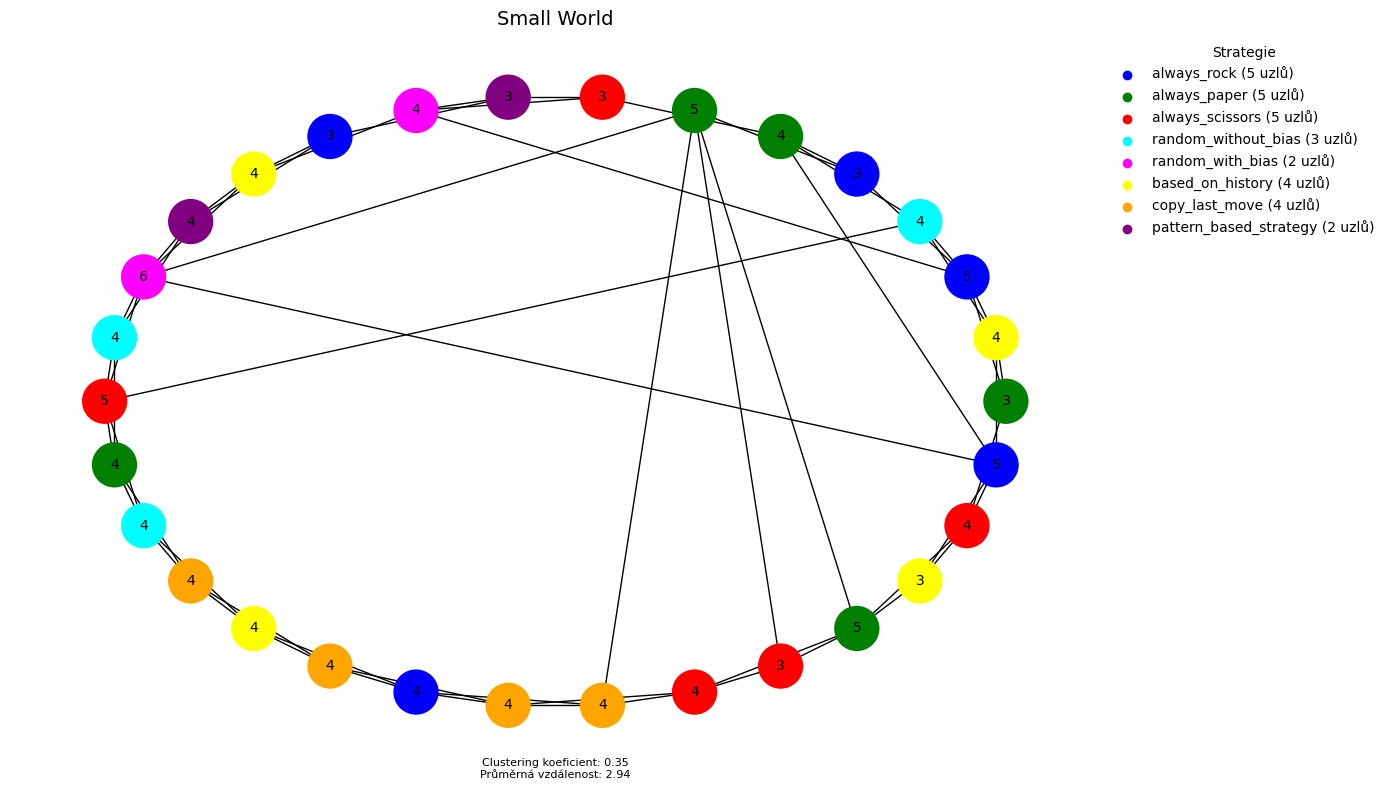

In [15]:
# Generování sítě malého světa
SW = nx.connected_watts_strogatz_graph(N, 4, p_edge_SW)
SW.graph['name'] = "Small World"

# Definice strategií pro každý uzel
node_strategy_SW = {node: random.choice(strategies) for node in SW.nodes()}

# Přiřazení strategických barev uzlům
node_colors = [strategy_colors[node_strategy_SW[node]] for node in SW.nodes()]

# Úprava popisu uzlů v grafu na jejich stupeň
node_labels = {node: SW.degree(node) for node in SW.nodes()}

# Vykreslení sítě s upravenými popisky uzlů a strategiemi
fig, ax = plt.subplots(figsize=(14, 8))
pos = nx.circular_layout(SW)

# Vykreslení uzlů s přiřazenými strategickými barvami a popisky
nx.draw(SW, pos, node_color=node_colors, with_labels=True, labels=node_labels, node_size=1000, font_size=10, ax=ax)

# Příprava dat pro legendu
legend_data = {strategy_names[strategy]: {'color': color, 'count': list(node_strategy_SW.values()).count(strategy)} for strategy, color in strategy_colors.items()}

# Vykreslení legendy s popisky strategií, jejich barev a počtu uzlů
for strategy, data in legend_data.items():
    plt.scatter([], [], c=data['color'], label=f"{strategy} ({data['count']} uzlů)")
plt.legend(scatterpoints=1, frameon=False, title='Strategie', bbox_to_anchor=(1, 1))

# Výpis a výpočet vlastností sítě
print_network_properties(SW, ax)

# Nastavení titulu a zobrazení grafu
ax.set_title(SW.graph['name'], fontsize=14, y=1)
plt.tight_layout()
plt.show()

### Síť s preferenčním připojováním
Zde používám funkci barabasi_albert_graph z knihovny Networkx ke generování grafu o *N* uzlech, který se rozrůstá připojením nových uzlů, z nichž každý má *num* hran, které jsou přednostně připojeny ke stávajícím uzlům s vysokým stupněm. [2]

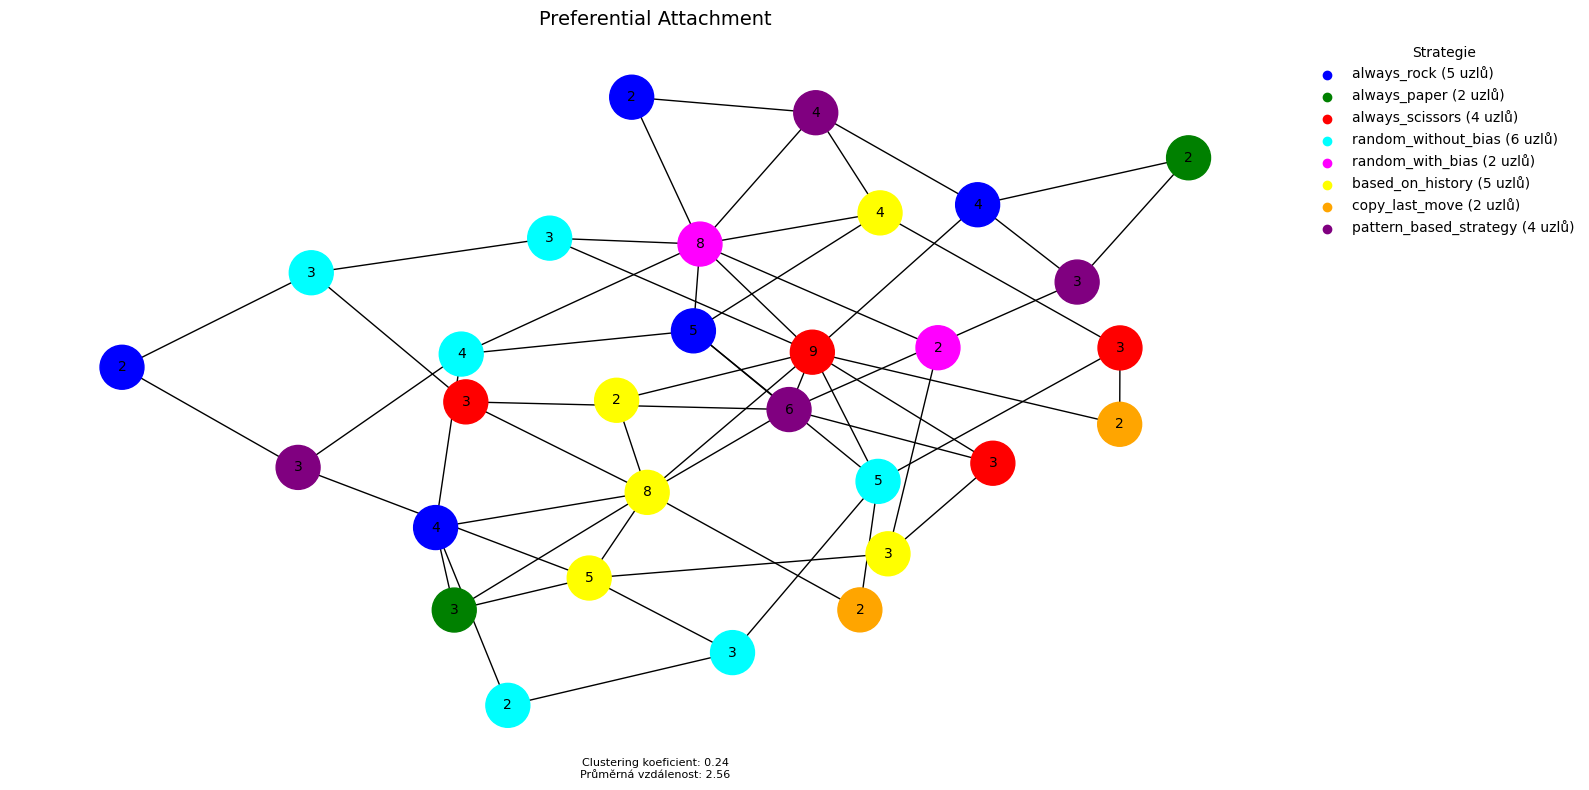

In [4]:
# Generování sítě preferenčního připojení s přiřazenou strategií pro každý uzel
PA = nx.barabasi_albert_graph(N, num)
PA.graph['name'] = "Preferential Attachment"

# Definice strategií pro každý uzel
node_strategy_PA = {node: random.choice(strategies) for node in PA.nodes()}

# Přiřazení strategických barev uzlům
node_colors = [strategy_colors[node_strategy_PA[node]] for node in PA.nodes()]

# Úprava popisu uzlů v grafu na jejich stupeň
node_labels = {node: PA.degree(node) for node in PA.nodes()}

# Vykreslení sítě s upravenými popisky uzlů a strategiemi
fig, ax = plt.subplots(figsize=(16, 8))
pos = nx.kamada_kawai_layout(PA)

# Vykreslení uzlů s přiřazenými strategickými barvami a popisky
nx.draw(PA, pos, node_color=node_colors, with_labels=True, labels=node_labels, node_size=1000, font_size=10, ax=ax)

# Příprava dat pro legendu
legend_data = {strategy_names[strategy]: {'color': color, 'count': list(node_strategy_PA.values()).count(strategy)} for strategy, color in strategy_colors.items()}

# Vykreslení legendy s popisky strategií, jejich barev a počtu uzlů
for strategy, data in legend_data.items():
    plt.scatter([], [], c=data['color'], label=f"{strategy} ({data['count']} uzlů)")
plt.legend(scatterpoints=1, frameon=False, title='Strategie', bbox_to_anchor=(1, 1))

# Výpis a výpočet vlastností sítě
print_network_properties(PA, ax)

# Nastavení titulu a zobrazení grafu
ax.set_title(PA.graph['name'], fontsize=14, y=1)
plt.tight_layout()
plt.show()

### Náhodná síť
Zde používám funkci erdos_renyi_graph z knihovny Networkx k vytvoření grafu z modelu, který vytvoří každou z možných hran s pravděpodobností p. [3]

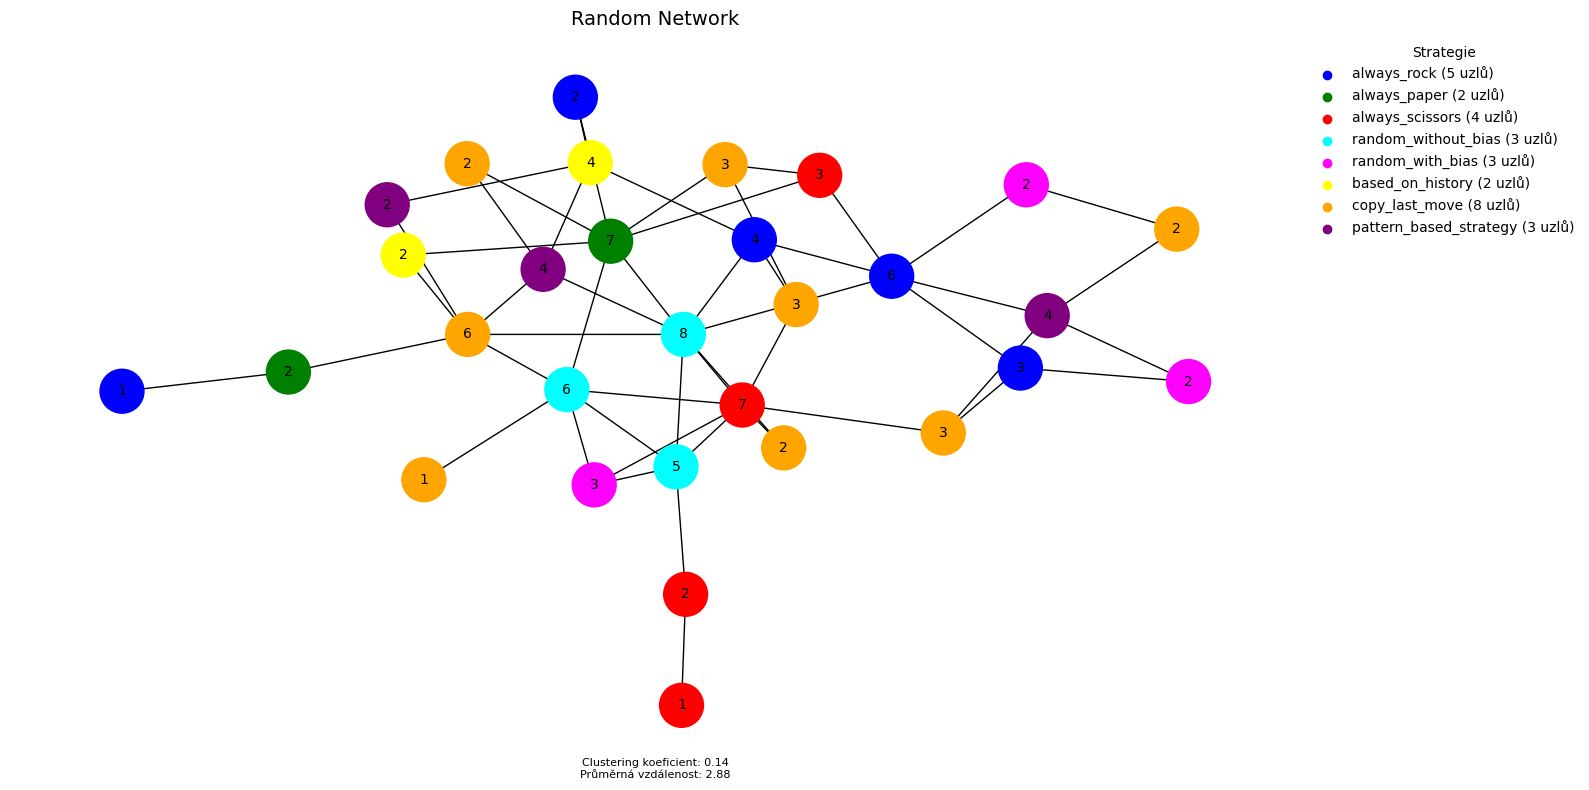

In [11]:
# Generování náhodné sítě s přiřazenou strategií pro každý uzel
RN = nx.erdos_renyi_graph(N, p_edge_RN)
RN.graph['name'] = "Random Network"

# Definice strategií pro každý uzel
node_strategy_RN = {node: random.choice(strategies) for node in RN.nodes()}

# Přiřazení strategických barev uzlům
node_colors = [strategy_colors[node_strategy_RN[node]] for node in RN.nodes()]

# Úprava popisu uzlů v grafu na jejich stupeň
node_labels = {node: RN.degree(node) for node in RN.nodes()}

# Vykreslení sítě s upravenými popisky uzlů a strategiemi
fig, ax = plt.subplots(figsize=(16, 8))
pos = nx.kamada_kawai_layout(RN)

# Vykreslení uzlů s přiřazenými strategickými barvami
nx.draw(RN, pos, node_color=node_colors, with_labels=True, labels=node_labels, node_size=1000, font_size=10, ax=ax)

# Příprava dat pro legendu
legend_data = {strategy_names[strategy]: {'color': color, 'count': list(node_strategy_RN.values()).count(strategy)} for strategy, color in strategy_colors.items()}

# Vykreslení legendy s popisky strategií, jejich barev a počtu uzlů
for strategy, data in legend_data.items():
    plt.scatter([], [], c=data['color'], label=f"{strategy} ({data['count']} uzlů)")
plt.legend(scatterpoints=1, frameon=False, title='Strategie', bbox_to_anchor=(1, 1))

# Výpis a výpočet vlastností sítě
print_network_properties(RN, ax)

# Nastavení titulu a zobrazení grafu
ax.set_title(RN.graph['name'], fontsize=14, y=1)
plt.tight_layout()
plt.show()

## Hra kámen nůžky papír
Otázka kterou by tato práce měla zodpovědět zní: Jsou strategie, založené na předchozích tazích protihráčů efektivnější než náhodné strategie? Případně jsou výrazné rozdíly v efektivitě těchto strategií v různých typech sítě?

### Hra
Definice toho jak funguje samotná hra kámen-nůžky-papír a jak fungují výplaty v této hře.

Rovněž je zde definice jak tato hra bude probíhat v grafech sítě. Implementováno je to tak že se jednodušše projdou všechny hrany sítě, tj. všechny spojení mezi hráči vedle sebe a ti spolu poté hrají.

Nutností bylo implementovat také paměť kam se ukládají tahy jednotlivých hráčů.

Jelikož jsem se rozhodl již dříve rozdělit náhodně jaké strategie a v jakém uzlu budou použity, tak je zde několik konstruktů, které mi umožní počítat procentuální úspěšnost jednotlivých strategií.

In [19]:
# Funkce pro hru kámen-nůžky-papír
def rock_paper_scissors(strategy1, strategy2, opponent_moves1, opponent_moves2):
    player1_move = strategy1(opponent_moves1)
    player2_move = strategy2(opponent_moves2)

    # Uložení zahrání tahů do historie
    opponent_moves1.append(player2_move)
    opponent_moves2.append(player1_move)

    if player1_move == player2_move:
        return "Remíza"
    elif (player1_move == "kámen" and player2_move == "nůžky") or \
         (player1_move == "nůžky" and player2_move == "papír") or \
         (player1_move == "papír" and player2_move == "kámen"):
        return strategy1  # Vrátí název strategie 1, pokud vyhrála
    else:
        return strategy2  # Vrátí název strategie 2, pokud vyhrála

def play_games_in_network(network, rounds, node_strategy):
    results = {strategy: 0 for strategy in node_strategy.values()}  # Počítadlo pro výsledky každé strategie
    results["Remíza"] = 0  # Hodnota pro remízu
    moves_played = {strategy: 0 for strategy in node_strategy.values()}  # Počítadlo pro každou strategii
    move_history = {node: [] for node in network.nodes()}  # Historie tahů každého uzlu
    for _ in range(rounds):
        for node in network.nodes():
            neighbors = list(network.neighbors(node))
            for neighbor in neighbors:
                opponent_moves1 = move_history[neighbor]  # Tahy protihráče pro hráče 1
                opponent_moves2 = move_history[node]     # Tahy protihráče pro hráče 2

                strategy1 = node_strategy[node]  # Strategie hráče 1
                strategy2 = node_strategy[neighbor]  # Strategie hráče 2
                result = rock_paper_scissors(strategy1, strategy2, opponent_moves1, opponent_moves2)
                results[result] += 1

                # Aktualizace move_history s posledními tahy hráčů
                move_history[node] = opponent_moves2
                move_history[neighbor] = opponent_moves1

                # Aktualizace počítadla pro použití strategie
                moves_played[strategy1] += 1
                moves_played[strategy2] += 1
    return results, moves_played

def calculate_win_rates(results, moves_played):
    win_rates = {}
    for strategy, wins in results.items():
        if strategy != "Remíza":
            total_games = moves_played[strategy]  # Celkový počet her, ve kterých hrála tato strategie
            win_rate = (wins / total_games) * 100 if total_games != 0 else 0  # Výpočet procentuálního podílu výher
            win_rates[strategy] = win_rate
    return win_rates

## Vizualizace výsledků

### Definice grafu


In [20]:
def visualize_results(results, G, moves_played):
    # Seznam možných voleb bez posledního výsledku (remíza vyrazena pro nezajimavost)
    choices = list(results.keys())[:-1]

    # Pořadí sloupců
    ordered_choices = [choice for choice in strategy_names if choice in choices]

    # Počty výher pro každou možnou volbu bez posledního výsledku, tj. remiza pro nezajimavost
    wins = [results[choice] for choice in ordered_choices]

    # Poměr výher k celkovému počtu odehraných her pro každou strategii
    win_ratios = [(wins[i] / moves_played[ordered_choices[i]]) * 100 if moves_played[ordered_choices[i]] != 0 else 0 for i in range(len(ordered_choices))]

    # Výběr barev pro sloupce
    colors = [strategy_colors[choice] for choice in ordered_choices]

    # Výška sloupců v grafu dle procentuálního poměru výher
    heights = win_ratios

    # Rozložení osy x pro umístění sloupců
    x = np.arange(len(ordered_choices))

    # Vykreslení grafu s rozšířením sloupců od sebe
    plt.bar(x, heights, color=colors)

    if 'name' in G.graph:
        plt.title(f'Výsledky na grafu {G.graph["name"]}')
    else:
        plt.title('Výsledky hry kámen-nůžky-papír')

    # Nahrazení funkcí jejich názvy v popisku osy x
    plt.xticks(x, [strategy_names[choice] for choice in ordered_choices], fontsize=8, rotation=45, ha='right')

    # Přidání procentuálních hodnot nad sloupce
    for i, win_count in enumerate(wins):
        strategy_name = ordered_choices[i]
        moves_played_strategy = moves_played[strategy_name]
        win_percentage = (win_count / moves_played_strategy) * 100 if moves_played_strategy != 0 else 0
        plt.text(x[i], heights[i] / 2, f'{win_percentage:.2f}%', ha='center', va='center', color='black')

    plt.ylabel('Procentuální úspěšnost')
    plt.xlabel('Strategie')
    plt.tight_layout()  # Pro zajištění správného rozložení grafu
    plt.show()

### Vizualizace
Konečná část práce poukazuje na samostatné výsledky kvůli kterým tato práce vznikla. Díky výše definovanému grafu můžeme velmi jednodušše vyčíst, která z mnou definovaných strategií byla nejúspěšnější. Tento experiment si můžeme velmi rychle znovu spustit na výše vygenerovaných sítích kolikrát chceme.

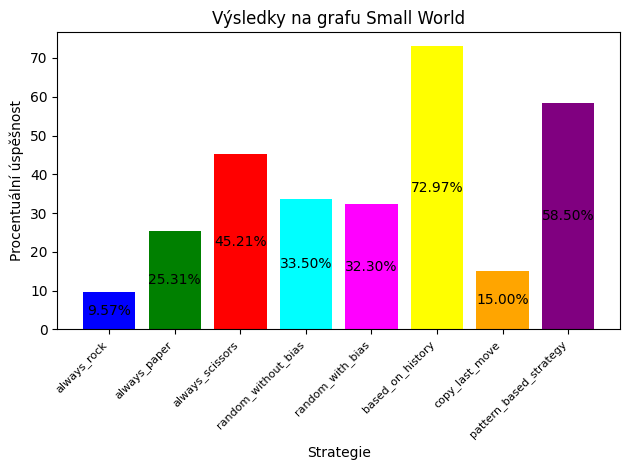

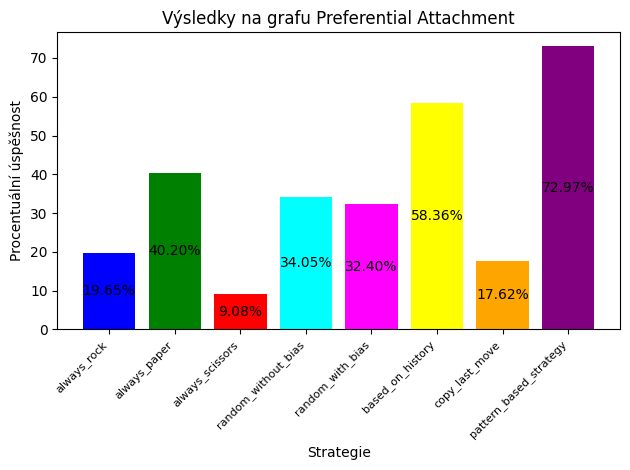

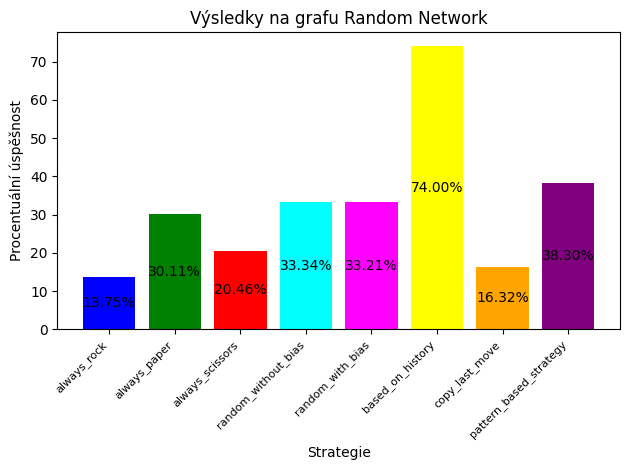

In [24]:
# Spusť hru na obou sitich a získej výsledky pro zadaný počet kol
resultsSW, moves_played_SW = play_games_in_network(SW, rounds, node_strategy_SW)
resultsPA, moves_played_PA = play_games_in_network(PA, rounds, node_strategy_PA)
resultsRN, moves_played_RN = play_games_in_network(RN, rounds, node_strategy_RN)

# Výpočet procentuální úspěšnosti pro každou strategii
win_rates_SW = calculate_win_rates(resultsSW, moves_played_SW)
win_rates_PA = calculate_win_rates(resultsPA, moves_played_PA)
win_rates_RN = calculate_win_rates(resultsRN, moves_played_RN)

# Vizualizace techto vysledku
visualize_results(resultsSW, SW, moves_played_SW)
visualize_results(resultsPA, PA, moves_played_PA)
visualize_results(resultsRN, RN, moves_played_RN)

### Závěr
Z opakovaných běhů této vizualizace lze jednoznačně zjistit, že strategie založené na využití historických dat protihráčových tahů tím nejvíce logickým způsobem, tj. strategie based_on_history a pattern_based_strategy, jsou nejvíce úspěšné. Prakticky nikdy nevyhrála jiná strategie, co je ovšem možná ještě zajímavější je fakt, že velmi často je jediným typem sítě kde vyhraje druhá zmíněná strategie oproti první, je síť s preferenčním připojováním. Toto pozorování by chtělo další zkoumání a výzkum.

## Zdroje
[1] síť malého světa: [connected_watts_strogatz_graph](https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.connected_watts_strogatz_graph.html#networkx.generators.random_graphs.connected_watts_strogatz_graph)

[2] síť s preferenčním připojováním: [barabasi_albert_graph](https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.barabasi_albert_graph.html)

[3] náhodná síť: [erdos_renyi_graph](https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.erdos_renyi_graph.html#networkx.generators.random_graphs.erdos_renyi_graph)